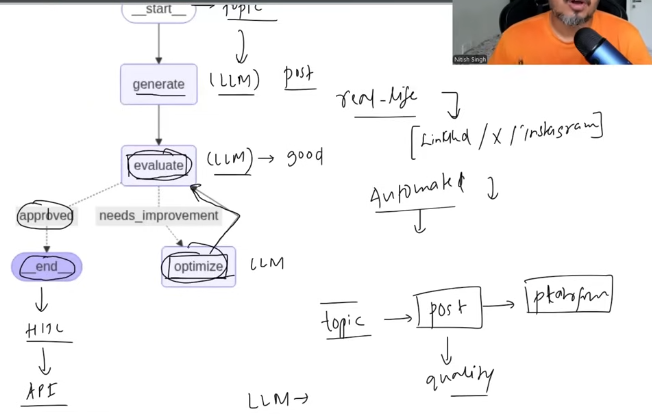

In [46]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict, Literal , Annotated
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage , HumanMessage
import operator

In [47]:
generator_llm = ChatGroq(model='llama-3.1-8b-instant')
evaluator_llm =  ChatGroq(model='llama-3.1-8b-instant')
optimizer_llm = ChatGroq(model='llama-3.1-8b-instant')

In [48]:
class TweetState(TypedDict):

    topic :str
    tweet :str
    evaluation : Literal['approved', 'needs_improvement']
    feedback : str
    iteration: int
    max_iteration : int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [49]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [50]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [51]:
def generate(state:TweetState):
    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
                    Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

                    Rules:
                    - Do NOT use question-answer format.
                    - Max 280 characters.
                    - Use observational humor, irony, sarcasm, or cultural references.
                    - Think in meme logic, punchlines, or relatable takes.
                    - Use simple, day to day english
                    """)
    ]
    #generaator_llm
    response = generator_llm.invoke(messages).content
    return {"tweet":response,'tweet_history': [response]}

In [52]:
def evaluate(state:TweetState):
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation , 'feedback': response.feedback , 'feedback_history': [response.feedback]}

In [53]:
def optimize(state:TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}
    

In [54]:
def route_evaluation(state: TweetState):
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

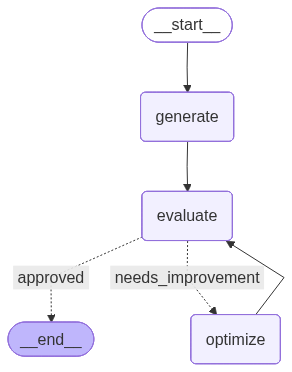

In [55]:
graph = StateGraph(TweetState)

graph.add_node('generate',generate)
graph.add_node('evaluate', evaluate)
graph.add_node('optimize', optimize)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow


In [65]:
initial_state = {
    "topic": "o0834yrvddas .aOWDKEWDWED",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [66]:
result

{'topic': 'o0834yrvddas .aOWDKEWDWED',
 'tweet': '"just stared at \'o0834yrvddas .aOWDKEWDWED\' for 10 minutes thinking it was a new font until I realized it\'s just me trying to write a password" #passwordprobs #fontfiasco',
 'evaluation': 'approved',
 'feedback': 'This tweet stands out for its originality and humor. The observation of mistaking a password for a new font is relatable and cleverly worded. However, the tweet could benefit from a more punchy delivery, as some may find the sentence structure a bit long for a Twitter post. Nevertheless, the viral potential is high, and the format is well-suited for the platform.',
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['"just stared at \'o0834yrvddas .aOWDKEWDWED\' for 10 minutes thinking it was a new font until I realized it\'s just me trying to write a password" #passwordprobs #fontfiasco'],
 'feedback_history': ['This tweet stands out for its originality and humor. The observation of mistaking a password for a new font